# Testing CCM

Original paper's [Github repo](https://github.com/Jianbo-Lab/CCM) and another [repo](https://github.com/jundongl/scikit-feature/tree/master/skfeature/data) with some of their data.

# Plan

** Things we will Examine **

1.   Model parameters : misspecification (i.e. `num_features`) and $\epsilon$ (they set at 0.001)
2.  different noise levels ($\epsilon$ in synthetic simulations)
3. with only feature selection, try to see if they select same features on different 80% splits (fix m, take 80% of data, get ranks for all features, and repeat)
4. Runtime


** How we will examine them **

1.   Evaluation of quality of chosen features (via median rank for simulated data and SVM accuracy on real data) varying `num_features` and $\epsilon$ for lactamase and 1 (of 1st and 3rd) (or 2) simulated datasets
2.   Evaluation of chosen features varying noise level in simulations (1st and 3rd dataset)
3. On simulated and real data, 10 times, take 80% of data, get ranks for all features and make box plots of the ranks. If its "stable" the boxes shouldn't be very tall; the rankings should be consistent no matter what 90% is chosen. Do this on lactamase and 1 simulated dataset.
4. Summarize runtime for each of our experiments

** Datasets of Interest **

* Real: Just one of P450 or lactamase
* Simulated: 1st or 3rd simulated datasets




## To-Do

* Make sure **all** plots make sense with Hao

# Setup

In [0]:
local = False  # Are we running on Colab or locally?

In [2]:
import warnings
import numpy as np
import pandas as pd
import sklearn.datasets as datasets
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.io import loadmat
import pdb
from tqdm import tqdm
import time
import tensorflow as tf 
import sys
import os

# Setting Path Structure
if local:
  path = ""
else:
  from google.colab import drive
  drive.mount('/content/gdrive')
  path = '/content/gdrive/My Drive/Research/Research Code/CCM/'
  from google.colab import files

# Adding CCM Modules
sys.path.append(path + "core")
sys.path.append(path + "examples")
import ccm
from kernel import GaussianKernel
from make_synthetic_data import generate_data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Note: their method requires that `X` and `Y` are both `ndarray`s.

They also use a Gaussian kernel function with a custom $\sigma$ definition. In terms of the `sklearn` Gaussian kernel parametrized by $\gamma$, $\gamma = \frac{1}{2\sigma^2}$

# Testing Functions

In [0]:
# Class for Hidden Printing
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
  
# # Used Like this
# with HiddenPrints():
#     print("This will not be printed")
# print("This will be printed as before")

## `CCM`

In [0]:
def default_num_features(X):
  """ X is data matrix as ndarray. """
  d = X.shape[1]
  if d > 100:
      num_features = 100
  else:
      num_features = np.ceil(d / 5)
  return(num_features)


def run_ccm(X, Y, type_Y, num_features = None, epsilon = 0.001):
  """ Assumes X and Y are ndarrays. We set num_features and epsilon to default
  values according to the paper. """
  
  # Setting num_features
  if num_features is None:
    num_features = default_num_features(X)
  
  # Running CCM
  print("Began CCM at", time.strftime("%H:%M:%S", time.gmtime()),
        "with num_features =", num_features, "and epsilon =",
        epsilon, "...", end = " ")
  ranks = ccm.ccm(X, Y, num_features, type_Y, epsilon, iterations = 100, verbose = False)
  print("CCM completed at ", time.strftime("%H:%M:%S", time.gmtime()), ".",
       sep = "")
  
  return(ranks)


def test_ccm(X, Y, ranks, test_log = True, step_rate = 1):
    """ Assumes X and Y are ndarrays. 
    Step alters the 'step' rate when testing different values of m. """
    
    # Enumerating m values as M
    d = X.shape[1]
    if d > 100:
        M = range(5, 105, 5*step_rate)
    else:
        M = range(1, d + 1, 1*step_rate)
    
    # Training SVMs for each m
    accs_svm, accs_log = dict.fromkeys(M), None
    if test_log:
      accs_log = dict.fromkeys(M)
    time.sleep(0.5)
    for m in tqdm(M):
        selected_feats = np.argsort(ranks)[:m]
        X_m = X[:, selected_feats]
        # Cross-validated SVM Accuracy
        k = 5
        kf = KFold(n_splits = k, shuffle = True)
        sum_accs_svm, sum_accs_log = 0, 0
        for train_index, test_index in kf.split(X_m):
            X_train, X_test = X_m[train_index], X_m[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            # Training
            sigma = np.median(squareform(pdist(X_train))) / np.sqrt(2)
            gamma = 1 / (2 * sigma**2)
            svm = SVC(C=1, kernel="rbf", gamma=gamma).fit(X_train, Y_train)
            if test_log:
              log = LogisticRegression(solver='lbfgs', max_iter=1e4, multi_class='ovr').fit(X_train, Y_train)
            # Evaluation
              sum_accs_svm += svm.score(X_test, Y_test)
            if test_log:
              sum_accs_log += log.score(X_test, Y_test)
        accs_svm[m] = sum_accs_svm / k
        if test_log:
          accs_log[m] = sum_accs_log / k
    time.sleep(0.5)
    
    return(accs_svm, accs_log)

## Varying `num_features`

In [0]:
def vary_n_features_real(X, Y, type_Y, step_rate = 1):  

  # Determining What Features to Test
  dnf = default_num_features(X)
  print("Default Number of Features =", dnf)
  list_nf = [np.ceil(dnf/2), dnf, 2*dnf]
  print("Number of Features to Test =", list_nf)
  list_accs_svm, list_accs_log = dict.fromkeys(list_nf), dict.fromkeys(list_nf)

  # Testing Different Values of num_features
  for nf in list_nf:
    ranks = run_ccm(X, Y, type_Y, num_features = nf)
    list_accs_svm[nf], list_accs_log[nf] = test_ccm(X, Y, ranks, step_rate=step_rate)
    
  return list_accs_svm, list_accs_log
  

def vary_n_features_sim(dataset, impo_feats, r = 10, seed = 0):
  
  np.random.seed(seed)
  
  # Dataset setup
  if dataset == 'orange_skin':
    type_Y = 'binary'
  elif dataset == 'regression':
    type_Y = 'real-valued'
  else:
    raise ValueError('Simulated dataset ' + dataset + ' does not exist.')
    
  # num_features to test
  list_nf = [i + 1 for i in range(10)]
  print('Testing num_features from 1 to 10.')
  median_ranks, se_ranks = dict.fromkeys(list_nf), dict.fromkeys(list_nf)
  
  # Testing each num_feature value
  time.sleep(0.5)
  for nf in tqdm(list_nf):
    r_median_ranks = np.zeros(r)
    for i in range(r):
      X, Y = generate_data(n=100, datatype=dataset, seed=np.random.randint(100))
      with HiddenPrints():
        ranks = run_ccm(X, Y, type_Y, num_features = nf)
      r_median_ranks[i] = np.median(ranks[impo_feats])
    median_ranks[nf] = np.mean(r_median_ranks)
    se_ranks[nf] = np.std(r_median_ranks)
  time.sleep(0.5)
  
  return median_ranks, se_ranks
    

## Varying $\epsilon$

In [0]:
def vary_epsilon_real(X, Y, type_Y, step_rate = 1):
  
  # Epsilons to test
  E = [0.00001,  0.001, 0.1] 
  list_accs_svm, list_accs_log = dict.fromkeys(E), dict.fromkeys(E)
  
  # Testing the different values of epsilon
  for e in E:
    ranks = run_ccm(X, Y, type_Y, epsilon = e)
    list_accs_svm[e], list_accs_log[e] = test_ccm(X, Y, ranks, step_rate = step_rate)
    
  return list_accs_svm, list_accs_log
  

def vary_epsilon_sim(dataset, impo_feats, r = 10, n = 100):
  
  np.random.seed(seed)
  
  # Dataset Setup
  if dataset == 'orange_skin':
    type_Y = 'binary'
  elif dataset == 'regression':
    type_Y = 'real-valued'
  else:
    raise ValueError('Simulated dataset ' + dataset + ' does not exist.')
  
  # Epsilons to test: 1ea to 1eb by 10 (number = b-a+1) 
  a, b = -5, 1
  e_powers = list(range(a, b + 1))
  print("Testing Epsilons from 1e", a, ' to 1e', b, sep='')
  median_ranks, se_ranks = dict.fromkeys(e_powers), dict.fromkeys(e_powers)
  
  # Testing different values of epsilon
  time.sleep(0.5)
  for power in tqdm(e_powers):
    r_median_ranks = np.zeros(r)
    e = 10**power
    for i in range(r):
      X, Y = generate_data(n=n, datatype=dataset, seed = np.random.randint(100))
      with HiddenPrints():
        ranks = run_ccm(X, Y, type_Y, epsilon = e)
      r_median_ranks[i] = np.median(ranks[impo_feats])
    median_ranks[power] = np.mean(r_median_ranks)
    se_ranks[power] = np.std(r_median_ranks)
  time.sleep(0.5)
    
  return median_ranks, se_ranks

## Plotting

* Good gradient color (`cmap`) [example](https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap) and [choices of colormaps](https://matplotlib.org/tutorials/colors/colormaps.html).
* How to [save figures](https://stackoverflow.com/questions/21875356/saving-a-figure-after-invoking-pyplot-show-results-in-an-empty-file).

In [0]:
RES = 500  # Resolution of plots


# Single parameter value on real dataset. Plots SVM and logistic accuracies at once.
def plot_accs(accs_svm, accs_log = None, title = None, ylims = None):
  fig, ax = plt.subplots()
  ax.plot(accs_svm.keys(), accs_svm.values(), label = "SVM")
  if accs_log is not None:
    ax.plot(accs_log.keys(), accs_log.values(), label = "Logistic")
  ax.legend(loc = "best")
  if title is not None:
    ax.set_title(title)
  if ylims is not None:
    ax.set_ylim(ylims)
  ax.set_xlabel("Number of Features Used to Train")
  ax.set_ylabel("Accuracy")
  plt.show()
  name = title + " plot_accs.png"
  fig.savefig(name, dpi = RES)

  
# For multiple parameter values for real dataset
def plot_multiple_accs(accs_dict, title, cmap, xlab = None, ylims = None):
  fig, ax = plt.subplots()
  n_lines = len(accs_dict)
  colors = dict(zip(accs_dict.keys(), cmap([(i+1) / n_lines for i in range(n_lines)])))
  for parameter in accs_dict:
    accs = accs_dict[parameter]
    ax.plot(accs.keys(), accs.values(), label = parameter, color = colors[parameter])
  ax.legend(loc = "best")
  ax.set_title(title)
  if ylims is not None:
    ax.set_ylim(ylims)
  if xlab is not None:
    ax.set_xlabel(xlab)
  ax.set_ylabel('Accuracy')
  plt.show()
  name = title + " " + xlab + " plot_multiple_accs.png"
  fig.savefig(name, dpi = RES)
  
  
# For multiple parameter values for simulated dataset
def plot_median_ranks(median_ranks, se, impo_feats, title, xlab, vert_line_x = None):
  fig, ax = plt.subplots()
  whiskers = [i for i in se.values()]
  ax.errorbar(median_ranks.keys(), median_ranks.values(), yerr = whiskers)
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel("Median Rank")
  lower_bound = (len(impo_feats) + 1) / 2
  ax.axhline(y=lower_bound, color='r', linestyle='-')
  if vert_line_x is not None:
    ax.axvline(x=vert_line_x, color = 'b', linestyle='--')
  plt.show()
  name = title + ' ' + xlab + ' plot_median_ranks.png'
  fig.savefig(name, dpi = RES)

# Loading Data

In [0]:
# Glass
glass = pd.read_csv(path + 'Paper Data/glass.csv', header = None)
X_glass, Y_glass = glass.iloc[:, :10].values, glass.iloc[:, 10].values

# warpAR10P
warpAR10P = loadmat(path + 'Paper Data/warpAR10P.mat')
X_warpAR10P, Y_warpAR10P = warpAR10P["X"].astype("int32"), warpAR10P["Y"].reshape(-1)

# warpPIE10P
warpPIE10P = loadmat(path + 'Paper Data/warpPIE10P.mat')
X_warpPIE10P, Y_warpPIE10P = warpPIE10P["X"].astype("int32"), warpPIE10P["Y"].reshape(-1)

# P450
P450 = pd.read_csv(path + "Structural Feature Data/P450.csv").drop(labels="Unnamed: 0", axis=1)
X_P450, Y_P450 = P450.drop("response", axis = 1).values, P450.loc[:, "response"].values
X_P450 = X_P450[:, np.std(X_P450, axis = 0) != 0]  # Removing column with std of 0

# Lactamase
lactamase = pd.read_csv(path + "Structural Feature Data/lactamase.csv").drop(labels="Unnamed: 0", axis=1)
X_lact, Y_lact = lactamase.drop("response", axis=1).values, lactamase.loc[:, "response"].values

# Binary
X_bin, Y_bin = generate_data(n=100, datatype='orange_skin', seed=0)
impo_feats_bin = [0, 1, 2, 3]  # Important features are first 4

# Additive Nonlinear Regression (ANR)
X_ANR, Y_ANR = generate_data(n=100, datatype='regression', seed = 0)
impo_feats_ANR = [0, 1, 2, 3]  # Important features are first 4

# Confirming Our Implementation

** Glass **

Similar but better accuracies than theirs.

Began CCM at 18:17:02 with num_features = 2.0 and epsilon = 0.001 ... CCM completed at 18:17:04.


100%|██████████| 10/10 [00:05<00:00,  1.24it/s]


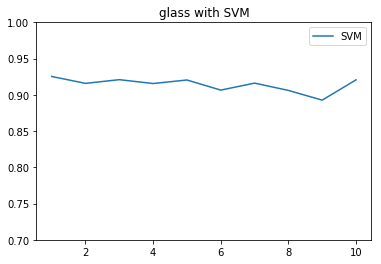

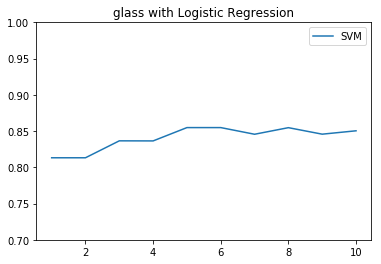

In [0]:
# Testing
ranks_glass = run_ccm(X_glass, Y_glass, 'categorical')
accs_glass_svm, accs_glass_log = test_ccm(X_glass, Y_glass, ranks_glass)

# Plotting
plot_accs(accs_glass_svm, title = "glass with SVM", ylims = (0.7, 1))
plot_accs(accs_glass_log, title = "glass with Logistic Regression", ylims = (0.7, 1))

** `warpAR10P`**

2,400 features. Colab recommended.

Accuracies look similar to theirs, just slightly worse.

In [0]:
ranks_warpAR10P = run_ccm(X_warpAR10P, Y_warpAR10P, 'categorical')
accs_warpAR10P_svm, accs_warpAR10P_log = test_ccm(X_warpAR10P, Y_warpAR10P, ranks_warpAP10P, test_log = True)
plot_accs(accs_warpAR10P_svm, title = "warpAR10P", ylims = (0.3, 1))

** `warpPIE10P` **

2,420 features. Colab recommended.

Accuracies ooks similar to theirs, only slightly worse.

Began CCM at 18:34:36... CCM completed at 18:38:02.


100%|██████████| 20/20 [00:40<00:00,  2.83s/it]


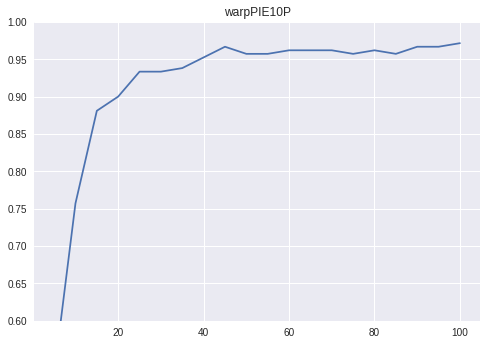

In [0]:
accs_warpPIE10P = ccm_svm(X_warpPIE10P, Y_warpPIE10P, 'categorical')
plot_accs(accs_warpPIE10P, "warpPIE10P", ylims = (0.6, 1))

# Default Results on Protein Datasets

## P450

Began CCM at 20:39:25 with num_features = 10.0 and epsilon = 0.001 ... CCM completed at 20:41:42.


100%|██████████| 50/50 [00:22<00:00,  1.58it/s]


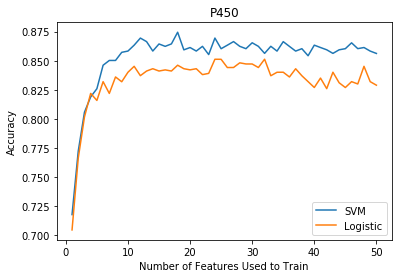

In [0]:
ranks_P450 = run_ccm(X_P450, Y_P450, 'binary')
accs_P450_svm, accs_P450_log = test_ccm(X_P450, Y_P450, ranks_P450, test_log = True)

plot_accs(accs_P450_svm, accs_P450_log, title = 'P450')

## Lactamase

Began CCM at 20:44:08 with num_features = 11.0 and epsilon = 0.001 ... CCM completed at 20:44:47.


100%|██████████| 51/51 [00:08<00:00,  3.97it/s]


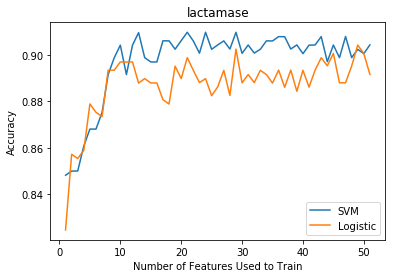

In [0]:
ranks_lact = run_ccm(X_lact, Y_lact, "binary")
accs_lact_svm, accs_lact_log = test_ccm(X_lact, Y_lact, ranks_lact)

plot_accs(accs_lact_svm, accs_lact_log, title = "lactamase")

# Varying `num_features`

## Lactamase


Default Number of Features = 11.0
Number of Features to Test = [6.0, 11.0, 22.0]
Began CCM at 20:36:43 with num_features = 6.0 and epsilon = 0.001 ... CCM completed at 20:37:27.


100%|██████████| 51/51 [00:09<00:00,  3.28it/s]


Began CCM at 20:37:38 with num_features = 11.0 and epsilon = 0.001 ... CCM completed at 20:38:21.


100%|██████████| 51/51 [00:08<00:00,  3.82it/s]


Began CCM at 20:38:30 with num_features = 22.0 and epsilon = 0.001 ... CCM completed at 20:39:12.


100%|██████████| 51/51 [00:09<00:00,  3.55it/s]


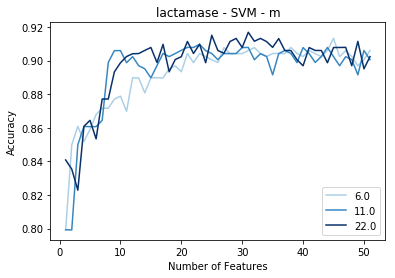

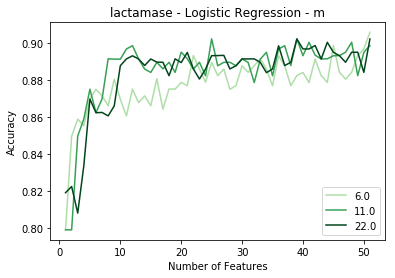

In [0]:
m_accs_lact_svm, m_accs_lact_log = vary_n_features_real(X_lact, Y_lact, 'binary')

plot_multiple_accs(accs_dict = m_accs_lact_svm, title = "lactamase - SVM - m", 
                   cmap = plt.cm.Blues, xlab ='Number of Features')
plot_multiple_accs(accs_dict = m_accs_lact_log, title = "lactamase - Logistic Regression - m",
                   cmap = plt.cm.Greens, xlab = 'Number of Features')

## Additive Nonlinear Regression

Testing num_features from 1 to 10.



100%|██████████| 10/10 [00:56<00:00,  5.52s/it]


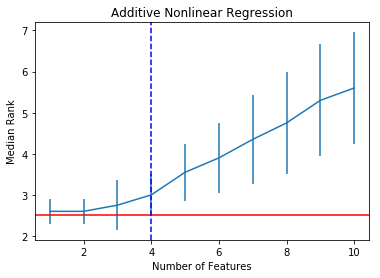

In [23]:
median_ranks_ANR_m, se_ranks_ANR_m = vary_n_features_sim('regression', impo_feats = impo_feats_ANR)

plot_median_ranks(median_ranks_ANR_m, se_ranks_ANR_m, impo_feats_ANR,
                  title="Additive Nonlinear Regression", xlab="Number of Features",
                  vert_line_x=len(impo_feats_ANR))

## Binary

Testing num_features from 1 to 10.



100%|██████████| 10/10 [00:56<00:00,  5.59s/it]


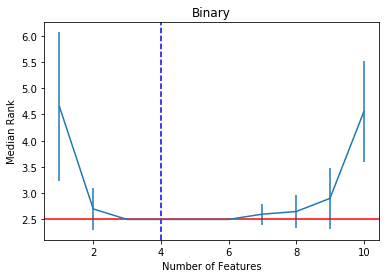

In [22]:
median_ranks_bin_m, se_ranks_bin_m = vary_n_features_sim('orange_skin', impo_feats=impo_feats_bin)

plot_median_ranks(median_ranks_bin_m, se_ranks_bin_m, impo_feats_bin, title='Binary', 
                  xlab="Number of Features", vert_line_x=len(impo_feats_bin))

# Varying $\epsilon$

## Lactamase

In [0]:
e_accs_lact_svm, e_accs_lact_log = vary_epsilon_real(X_lact, Y_lact, type_Y = "binary")


plot_multiple_accs(accs_dict = e_accs_lact_svm, title = "lactamase - SVM - Epsilon", 
                   cmap = plt.cm.Blues, xlab ='Number of Features')
plot_multiple_accs(accs_dict = e_accs_lact_log, title = "lactamase - Logistic Regression - Epsilon",
                   cmap = plt.cm.Greens, xlab = 'Number of Features')

## Additive Nonlinear Regression

Testing Epsilons from 1e-5 to 1e1



100%|██████████| 7/7 [00:39<00:00,  5.61s/it]


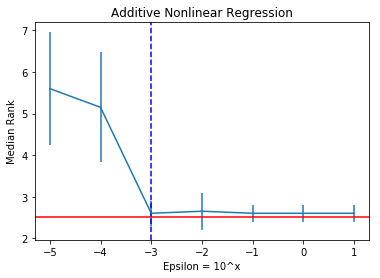

In [25]:
median_ranks_ANR_e, se_ranks_ANR_e = vary_epsilon_sim('regression', impo_feats_ANR)

plot_median_ranks(median_ranks_ANR_e, se_ranks_ANR_e, impo_feats_ANR, title="Additive Nonlinear Regression", 
                  xlab="Epsilon = 10^x", vert_line_x=-3)

## Binary

Testing Epsilons from 1e-5 to 1e1


100%|██████████| 7/7 [00:40<00:00,  5.82s/it]


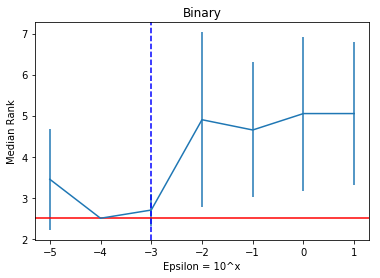

In [12]:
median_ranks_bin_e, se_ranks_bin_e = vary_epsilon_sim('orange_skin', impo_feats_bin)

plot_median_ranks(median_ranks_bin_e, se_ranks_bin_e, impo_feats_bin, title="Binary", 
                    xlab="Epsilon = 10^x", vert_line_x=-3)

### Bigger Sample

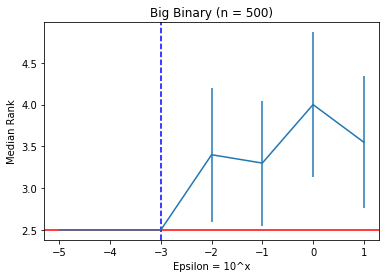

In [43]:
n = 500

# median_ranks_bin_big_e, se_ranks_bin_big_e = vary_epsilon_sim('orange_skin', impo_feats_bin, n = n)

plot_median_ranks(median_ranks_bin_big_e, se_ranks_bin_big_e, impo_feats_bin,
                  title=("Big Binary (n = "+str(n)+")"), xlab="Epsilon = 10^x",
                  vert_line_x=-3)

# Varying Noise in Additive Nonlinear Regression

**Model**: $ Y=-2 \sin \left(2 X_{1}\right)+\max \left(X_{2}, 0\right)+X_{3}+\exp \left(-X_{4}\right)+\varepsilon$ where $\left(X_{1}, \ldots, X_{10}\right) \sim N\left(0, I_{10}\right)$ and  $\varepsilon \sim N(0,1)$.

We increase the variance of $\varepsilon$.

Testing SE from 1 to 11







  0%|          | 0/10 [00:00<?, ?it/s]




 10%|█         | 1/10 [00:08<01:16,  8.48s/it]




 20%|██        | 2/10 [00:16<01:07,  8.44s/it]




 30%|███       | 3/10 [00:25<00:59,  8.46s/it]




 40%|████      | 4/10 [00:33<00:50,  8.47s/it]




 50%|█████     | 5/10 [00:42<00:42,  8.50s/it]




 60%|██████    | 6/10 [00:51<00:34,  8.58s/it]




 70%|███████   | 7/10 [00:59<00:25,  8.54s/it]




 80%|████████  | 8/10 [01:08<00:17,  8.53s/it]




 90%|█████████ | 9/10 [01:16<00:08,  8.50s/it]




100%|██████████| 10/10 [01:25<00:00,  8.52s/it]






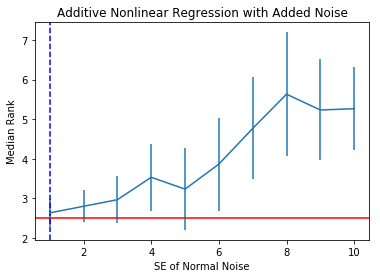

In [39]:
# np.random.seed(19)

# Noise levels to test
max_s = 11
S = list(range(1, max_s))
print("Testing SE from 1 to", max_s)
median_ranks_added_noise, se_added_noise = dict.fromkeys(S), dict.fromkeys(S)

# Testing different values of s
impo_feats = [0, 1, 2, 3]
r = 15
time.sleep(0.5)
for s in tqdm(S):
  r_median_ranks = np.zeros(r)
  for i in range(r):
    new_seed = np.random.randint(100)
#     print(new_seed)
    X, Y = generate_data(n=100, datatype='regression', seed=new_seed, ANR_e_scale=s)
    with HiddenPrints():
      ranks = run_ccm(X, Y, type_Y = 'real-valued')
#     print(ranks[impo_feats])
    r_median_ranks[i] = np.median(ranks[impo_feats])
  median_ranks_added_noise[s] = np.mean(r_median_ranks)
  se_added_noise[s] = np.std(r_median_ranks)
time.sleep(0.5)

# Plotting
plot_median_ranks(median_ranks_added_noise, se_added_noise, impo_feats_ANR, 
                  title = 'Additive Nonlinear Regression with Added Noise',
                  xlab = 'SE of Normal Noise', vert_line_x = 1)

# Runtime Summary

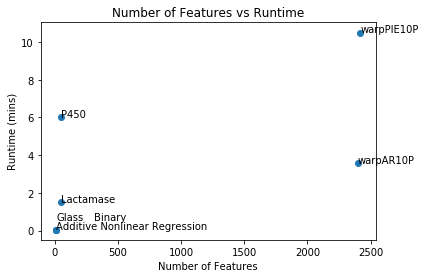

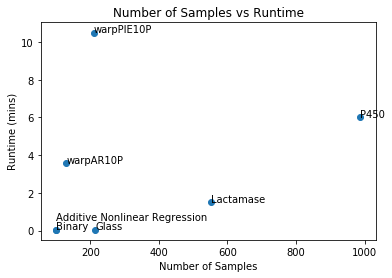

In [0]:
#### Data ####

names = ['Glass', 'warpAR10P', 'warpPIE10P', 'P450', 'Lactamase', 
         'Additive Nonlinear Regression', 'Binary']
google_runtimes = [1/60, 1.2, 3.5, 2, .5, 1/60, 1/60]  # Minutes
runtimes = [3*i for i in google_runtimes]
num_features = [10, 2400, 2420, 51, 51, 10, 10]
n = [214, 130, 210, 988, 553, 100, 100]

#### Plotting ####

fig, ax = plt.subplots()
ax.scatter(num_features, runtimes)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Runtime (mins)')
ax.set_title('Number of Features vs Runtime')
for i, txt in enumerate(names):
  if txt == 'Glass':
    ax.annotate(txt, (num_features[i], runtimes[i]+.5))
  elif txt == 'Binary':
    ax.annotate(txt, (num_features[i]+300, runtimes[i]+0.5))
  else:
    ax.annotate(txt, (num_features[i], runtimes[i]))
fig.savefig("Number of Features vs Runtime.png", dpi = RES)
plt.show()

fig, ax = plt.subplots()
ax.scatter(n, runtimes)
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Runtime (mins)')
ax.set_title('Number of Samples vs Runtime')
for i, txt in enumerate(names):
  if txt == 'Additive Nonlinear Regression':
    ax.annotate(txt, (n[i], runtimes[i]+0.5))
  else:
    ax.annotate(txt, (n[i], runtimes[i]))
fig.savefig("Number of Samples vs Runtime.png", dpi = RES)
plt.show()